# Imports

In [28]:
# for importing code
import sys, os

module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)

In [29]:
import pandas as pd
from constants import PROJECT_ROOT

# created by: uv run python src/classify_twitter_posts.py --model anthropic/claude-sonnet-4 --temperature 0.1 --n-samples 750 --min-chars 50 --results_filename twitter_posts_classified
path = f"{PROJECT_ROOT}/datasets/train_test_datasets/train.csv"
df = pd.read_csv(path)
df.shape

(1529, 20)

Train size: 1070, Test size: 459
Confusion matrix (rows true, cols pred):
        pred_0  pred_1
true_0     362       1
true_1      87       9

Accuracy: 0.8082788671023965

Classification report:
              precision    recall  f1-score   support

           0      0.806     0.997     0.892       363
           1      0.900     0.094     0.170        96

    accuracy                          0.808       459
   macro avg      0.853     0.545     0.531       459
weighted avg      0.826     0.808     0.741       459



Text(70.7222222222222, 0.5, 'Actual')

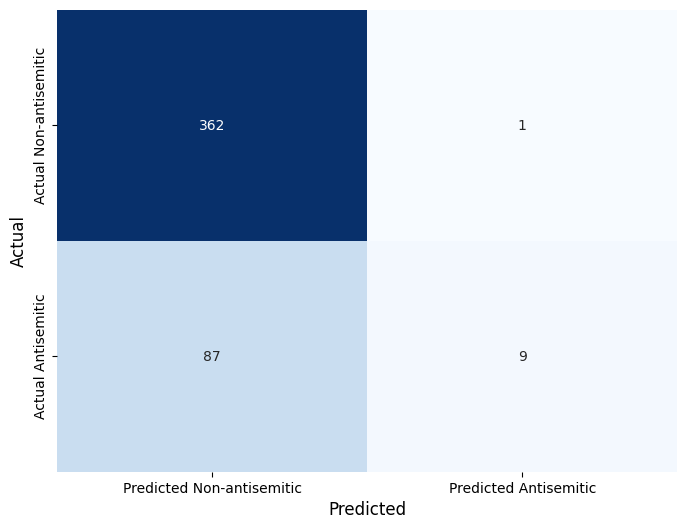

In [30]:
# Minimal TF-IDF + Logistic Regression on df[Text, Biased]

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Assume you already have a DataFrame `df` with columns: "Text" (str), "Biased" (0 or 1)
# Light hygiene in case there are NaNs
df_use = df[["Text", "Biased"]].dropna()
X = df_use["Text"].astype(str)
y = df_use["Biased"].astype(int)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
# Build pipeline
clf = make_pipeline(
    TfidfVectorizer(),  # default settings, no extra preprocessing
    LogisticRegression(max_iter=1000),  # simple baseline
)

# Train
clf.fit(X_train, y_train)

# Predict on test
y_pred = clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=["true_0", "true_1"], columns=["pred_0", "pred_1"])
print("Confusion matrix (rows true, cols pred):")
print(cm_df)

# Simple scores
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Predicted Non-antisemitic", "Predicted Antisemitic"],
    yticklabels=["Actual Non-antisemitic", "Actual Antisemitic"],
    ax=ax,
)


ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)

In [31]:
# TF-IDF -> KMeans(k=10) -> t-SNE(2D) -> Plotly hover with <br> every 15 words

# pip install plotly scikit-learn

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import plotly.express as px


def wrap_every_n_words(s: str, n: int = 15, br: str = "<br>") -> str:
    words = s.split()
    return br.join(" ".join(words[i : i + n]) for i in range(0, len(words), n))


df_sampled = df.sample(500, random_state=42)
# 1) TF-IDF
texts = df_sampled["Text"].astype(str).fillna("")
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)
X = vectorizer.fit_transform(texts)

# 2) KMeans on TF-IDF
k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_ids = kmeans.fit_predict(X)
df_sampled["cluster_id"] = cluster_ids

# 3) Dim reduction then t-SNE (t-SNE works better after SVD on sparse TF-IDF)
svd = TruncatedSVD(n_components=50, random_state=42)
X_50 = svd.fit_transform(X)

# t-SNE params (perplexity must be < n_samples)
n_samples = len(texts)
perplexity = max(5, min(30, n_samples - 1))  # safe default
tsne = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=perplexity,
    random_state=42,
)
coords_2d = tsne.fit_transform(X_50)

# 4) Viz df with wrapped text for hover
viz_df = pd.DataFrame(
    {
        "x": coords_2d[:, 0],
        "y": coords_2d[:, 1],
        "cluster_id": cluster_ids.astype(str),
        "text_wrapped": [wrap_every_n_words(t, 15) for t in texts],
    }
)

# 5) Plotly scatter with hover
fig = px.scatter(
    viz_df,
    x="x",
    y="y",
    color="cluster_id",
    title="TF-IDF KMeans Clusters (k=10) with t-SNE",
    custom_data=["text_wrapped", "cluster_id"],
)
fig.update_traces(
    marker=dict(size=7, opacity=0.85),
    hovertemplate="%{customdata[0]}<br><b>cluster:</b> %{customdata[1]}<extra></extra>",
)
fig.update_layout(legend_title_text="cluster_id")
fig.show()